# ANPR


Your secrets.ini file should include the access key and url for the published customvision.ai prediction api and the Azure Cognitive Services instance. 

The format of the file is as follows: 
```
[custom_vision]
key = <your published prediction api key>
url = <URL for published custom vision prediction api, should end with /url>
imgurl = <URL for published custom vision predicition api, should end with /image>

[computer_vision]
key = <your computer vision api key>
url = https://australiaeast.api.cognitive.microsoft.com/ 
```

In [1]:
import configparser

config = configparser.ConfigParser()
config.read('secrets.ini')

# custom vision api
custom_vision_key = config['custom_vision']['key']
custom_vision_url = config['custom_vision']['url']
custom_vision_imgurl = config['custom_vision']['imgurl']

# computer vision text recognition api
subscription_key = config['computer_vision']['key']
endpoint = config['computer_vision']['url']
text_recognition_url = endpoint + "vision/v2.1/read/core/asyncBatchAnalyze"

In [2]:
import os
import sys
import requests
import time
import json
import base64
import numpy as np
import pandas as pd
from io import BytesIO
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from io import BytesIO


In [79]:
def get_plate(filename, threshold = .8, show_img=False, v=False): 

    data = open(filename, 'rb').read()
    custom_vision_headers = {'Content-Type': 'application/octet-stream', 'Prediction-Key': custom_vision_key}
    img = cv2.imdecode(np.array(bytearray(data), dtype='uint8'), cv2.IMREAD_COLOR)
    custom_vision_resp = requests.post(url=custom_vision_imgurl, data=data, headers=custom_vision_headers).json()
    # inspect the top result, based on probability 
    
    tophits = pd.DataFrame(custom_vision_resp['predictions']).sort_values(by='probability',ascending=False)
    print(type(tophits))
    tophits = tophits[tophits.probability >= threshold]
    print(type(tophits))
    

    img2 = img 
    if v is True: 
        print('tophits')
        print(tophits)


    print(tophits.columns)
    tophits['img_crop'] = None
    print(tophits.columns)
    for i, r in tophits.iterrows(): 
        print(i)
        print(r, type(r))
        hit = r.to_dict()
        print(hit)
        print(hit['boundingBox'])
    
        # extract the bounding box for the detected number plate 
        boundingbox = hit['boundingBox']
        l,t,w,h = (boundingbox['left'], boundingbox['top'], boundingbox['width'], boundingbox['height'])
        polylines1 = np.multiply([[l,t],[l+w,t],[l+w,t+h],[l,t+h]], [img.shape[1],img.shape[0]])
        if v is True: 
            print(l,t,w,h)
            print('width, height')
            print(img.shape[1],img.shape[0])
            print([[l,t],[l+w,t],[l,t+h],[l+w,t+h]])
            print(polylines1)

        # draw object boundries 
        img2 = cv2.polylines(img2, np.int32([polylines1]), 1, (255,255,0), 4, lineType=cv2.LINE_AA )

        # crop the image to the bounding box of the rego plate
        crop_x = polylines1[:,0].astype('uint16')
        crop_y = polylines1[:,1].astype('uint16')
        img_crop = img[np.min(crop_y):np.max(crop_y), np.min(crop_x):np.max(crop_x)]
        
        print(len(tophits))
        if v is True: 
            print(np.min(crop_y),np.min(crop_x), np.max(crop_y),np.max(crop_x))
            print(img2.shape)
            print(img_crop.shape)


        if show_img is True: 
            # display the detected rego plate region
            plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
            plt.show()
    
    for r in tophits: 

        if show_img is True: 
            # display the cropped rego plate region
            plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))
            plt.show()

    return tophits, img2

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
tophits
    probability                                 tagId tagName  \
6      0.980954  1752966c-d1e1-46f5-924b-505d90a16981   plate   
22     0.977807  1752966c-d1e1-46f5-924b-505d90a16981   plate   
17     0.899390  1752966c-d1e1-46f5-924b-505d90a16981   plate   
1      0.896705  1752966c-d1e1-46f5-924b-505d90a16981   plate   
8      0.817705  1752966c-d1e1-46f5-924b-505d90a16981   plate   

                                          boundingBox  
6   {'left': 0.252694845, 'top': 0.432022542, 'wid...  
22  {'left': 0.5978148, 'top': 0.507135749, 'width...  
17  {'left': 0.230523661, 'top': 0.0032566376, 'wi...  
1   {'left': 0.302684128, 'top': 0.01450819, 'widt...  
8   {'left': 0.659152448, 'top': 0.5189746, 'width...  
Index(['probability', 'tagId', 'tagName', 'boundingBox'], dtype='object')
Index(['probability', 'tagId', 'tagName', 'boundingBox', 'img_crop'], dtype='object')
6
probability                

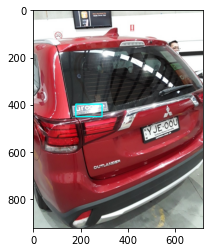

22
probability                                             0.977807
tagId                       1752966c-d1e1-46f5-924b-505d90a16981
tagName                                                    plate
boundingBox    {'left': 0.5978148, 'top': 0.507135749, 'width...
img_crop                                                    None
Name: 22, dtype: object <class 'pandas.core.series.Series'>
{'probability': 0.977807462, 'tagId': '1752966c-d1e1-46f5-924b-505d90a16981', 'tagName': 'plate', 'boundingBox': {'left': 0.5978148, 'top': 0.507135749, 'width': 0.317241967, 'height': 0.07819164}, 'img_crop': None}
{'left': 0.5978148, 'top': 0.507135749, 'width': 0.317241967, 'height': 0.07819164}
0.5978148 0.507135749 0.317241967 0.07819164
width, height
720 923
[[0.5978148, 0.507135749], [0.915056767, 0.507135749], [0.5978148, 0.585327389], [0.915056767, 0.585327389]]
[[430.426656   468.08629633]
 [658.84087224 468.08629633]
 [658.84087224 540.25718005]
 [430.426656   540.25718005]]
5
468 430 540 658
(

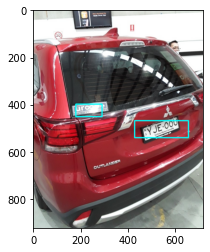

17
probability                                              0.89939
tagId                       1752966c-d1e1-46f5-924b-505d90a16981
tagName                                                    plate
boundingBox    {'left': 0.230523661, 'top': 0.0032566376, 'wi...
img_crop                                                    None
Name: 17, dtype: object <class 'pandas.core.series.Series'>
{'probability': 0.89939034, 'tagId': '1752966c-d1e1-46f5-924b-505d90a16981', 'tagName': 'plate', 'boundingBox': {'left': 0.230523661, 'top': 0.0032566376, 'width': 0.234701976, 'height': 0.08515811}, 'img_crop': None}
{'left': 0.230523661, 'top': 0.0032566376, 'width': 0.234701976, 'height': 0.08515811}
0.230523661 0.0032566376 0.234701976 0.08515811
width, height
720 923
[[0.230523661, 0.0032566376], [0.46522563699999997, 0.0032566376], [0.230523661, 0.0884147476], [0.46522563699999997, 0.0884147476]]
[[165.97703592   3.0058765 ]
 [334.96245864   3.0058765 ]
 [334.96245864  81.60681203]
 [165.97703592  8

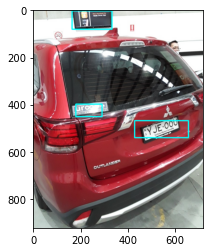

1
probability                                             0.896705
tagId                       1752966c-d1e1-46f5-924b-505d90a16981
tagName                                                    plate
boundingBox    {'left': 0.302684128, 'top': 0.01450819, 'widt...
img_crop                                                    None
Name: 1, dtype: object <class 'pandas.core.series.Series'>
{'probability': 0.8967051, 'tagId': '1752966c-d1e1-46f5-924b-505d90a16981', 'tagName': 'plate', 'boundingBox': {'left': 0.302684128, 'top': 0.01450819, 'width': 0.131525338, 'height': 0.0544762164}, 'img_crop': None}
{'left': 0.302684128, 'top': 0.01450819, 'width': 0.131525338, 'height': 0.0544762164}
0.302684128 0.01450819 0.131525338 0.0544762164
width, height
720 923
[[0.302684128, 0.01450819], [0.434209466, 0.01450819], [0.302684128, 0.0689844064], [0.434209466, 0.0689844064]]
[[217.93257216  13.39105937]
 [312.63081552  13.39105937]
 [312.63081552  63.67260711]
 [217.93257216  63.67260711]]
5
13 217 6

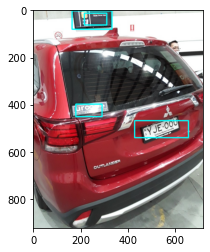

8
probability                                             0.817705
tagId                       1752966c-d1e1-46f5-924b-505d90a16981
tagName                                                    plate
boundingBox    {'left': 0.659152448, 'top': 0.5189746, 'width...
img_crop                                                    None
Name: 8, dtype: object <class 'pandas.core.series.Series'>
{'probability': 0.8177052, 'tagId': '1752966c-d1e1-46f5-924b-505d90a16981', 'tagName': 'plate', 'boundingBox': {'left': 0.659152448, 'top': 0.5189746, 'width': 0.178371191, 'height': 0.07970959}, 'img_crop': None}
{'left': 0.659152448, 'top': 0.5189746, 'width': 0.178371191, 'height': 0.07970959}
0.659152448 0.5189746 0.178371191 0.07970959
width, height
720 923
[[0.659152448, 0.5189746], [0.8375236389999999, 0.5189746], [0.659152448, 0.59868419], [0.8375236389999999, 0.59868419]]
[[474.58976256 479.0135558 ]
 [603.01702008 479.0135558 ]
 [603.01702008 552.58550737]
 [474.58976256 552.58550737]]
5
479 474 5

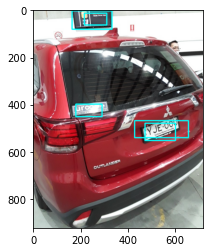

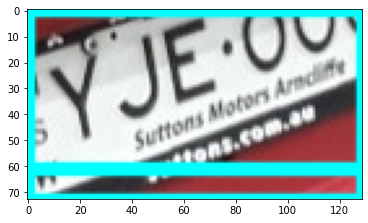

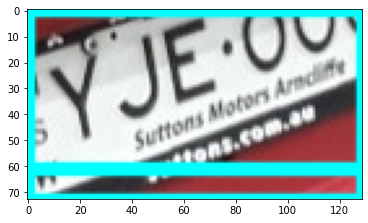

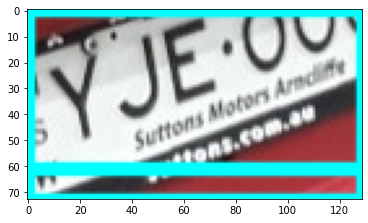

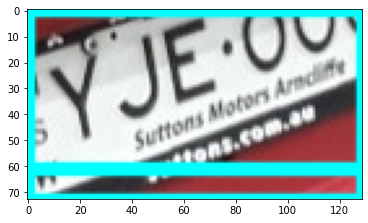

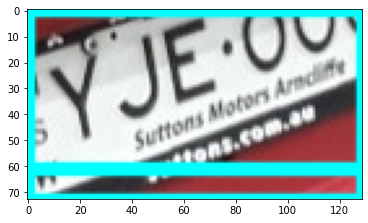

In [80]:
filename = 'anpr_transport\\YJE00U.jpg'
tophits, img = get_plate(filename, show_img=True, v=True)




# Text recognition 

In this section, the cropped image for the detected rego plate is sent to the text extraction API. 

Extracting text requires two API calls: One call to submit the image for processing, the other to retrieve the text found in the image.


In [ ]:
# convert the cv2 image to bytes array so we can send it over the wire to the API 
crop_bytes =bytes(cv2.imencode('.jpg', img_crop)[1])

In [ ]:
# make a call to the text_recognition_url
response = requests.post(
    url=text_recognition_url, 
    data=crop_bytes, 
    headers={'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'})


In [ ]:
# Holds the URI used to retrieve the recognized text.
response.raise_for_status()
operation_url = response.headers["Operation-Location"]

In [ ]:
# The recognized text isn't immediately available, so poll to wait for completion.
analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers={'Ocp-Apim-Subscription-Key': subscription_key})
    analysis = response_final.json()
    print(analysis)
    time.sleep(1)
    if ("recognitionResults" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'Failed'):
        poll = False


In [ ]:
for i,l in enumerate(analysis['recognitionResults'][0]['lines']): 
    print(i, ': text found: ', [w['text'] for w in l['words']])

In [ ]:
plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))
